In [81]:
import numpy as np
import pandas as pd
import yfinance as fix
import pandas_datareader.data as pdr
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')
fix.pdr_override()
import pandas as pd
from prophet import Prophet
# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data.to_csv("MSFT.csv")

In [3]:
data = GetData("MSFT", "2017-01-01", "2021-03-31")
data.get_stock_data()

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data = pd.read_csv("MSFT.csv")

In [5]:
#Select and rename columns for prophet
stock_data = stock_data[['Date','Close']]
stock_data = stock_data.rename(columns = {'Date':'ds','Close':'y'})

In [6]:
# Extract the 'Date' column and use it as the index in separate df
stock_data_ = stock_data.copy()
stock_data_.loc[:, 'ds'] = pd.to_datetime(stock_data['ds'])
stock_data_.set_index('ds', inplace=True)

C:\Users\noahc\AppData\Local\Temp\ipykernel_10236\3341604650.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stock_data_.loc[:, 'ds'] = pd.to_datetime(stock_data['ds'])


In [7]:
# Split the data into training and test sets
train_data = stock_data[0:len(stock_data_[stock_data_.index.year != 2021])]
test_data = stock_data[len(stock_data_[stock_data_.index.year != 2021]):]

In [8]:
len(train_data)

1007

In [9]:
len(test_data)

60

In [10]:
len(stock_data)

1067

# Fit model using all of the data (incl. Q1 2021)

In [207]:
model = Prophet()

In [208]:
model.fit(stock_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [209]:
future = model.make_future_dataframe(periods=92,include_history=True)
future.tail()

,ds
1154,2021-06-26
1155,2021-06-27
1156,2021-06-28
1157,2021-06-29
1158,2021-06-30


In [210]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365)

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
794,2020-03-02,172.794248,167.927328,177.952043
795,2020-03-03,164.509974,159.041207,169.837410
796,2020-03-04,170.551479,165.482453,175.628814
797,2020-03-05,166.271916,160.818625,171.579667
798,2020-03-06,161.570450,156.261640,167.012821
...,...,...,...,...
1154,2021-06-26,258.739334,251.861354,265.671255
1155,2021-06-27,259.040167,252.549124,265.896707
1156,2021-06-28,261.440273,254.713847,268.681414
1157,2021-06-29,261.741781,254.815654,268.349676


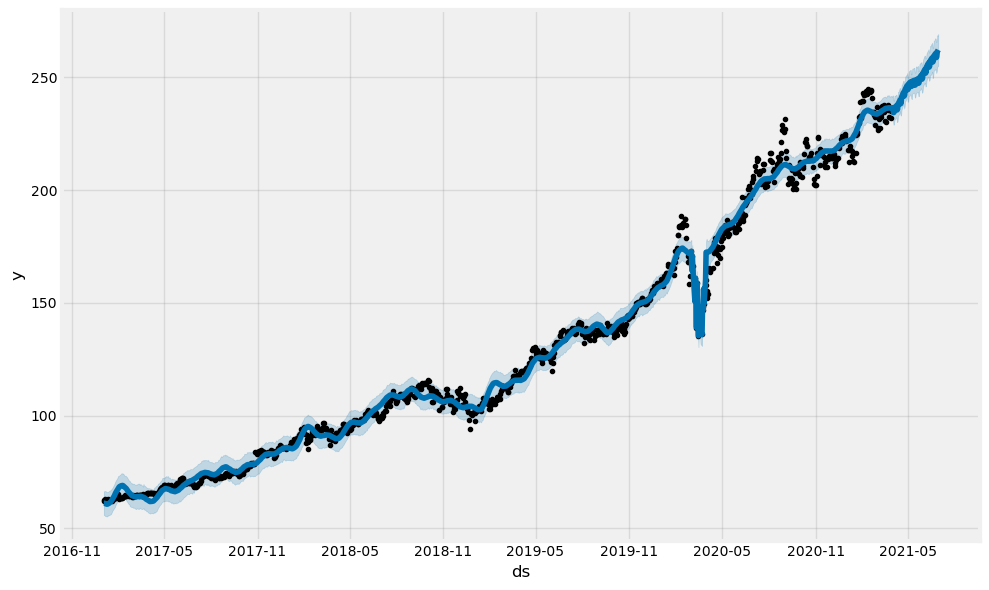

In [211]:
fig1 = model.plot(forecast)

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



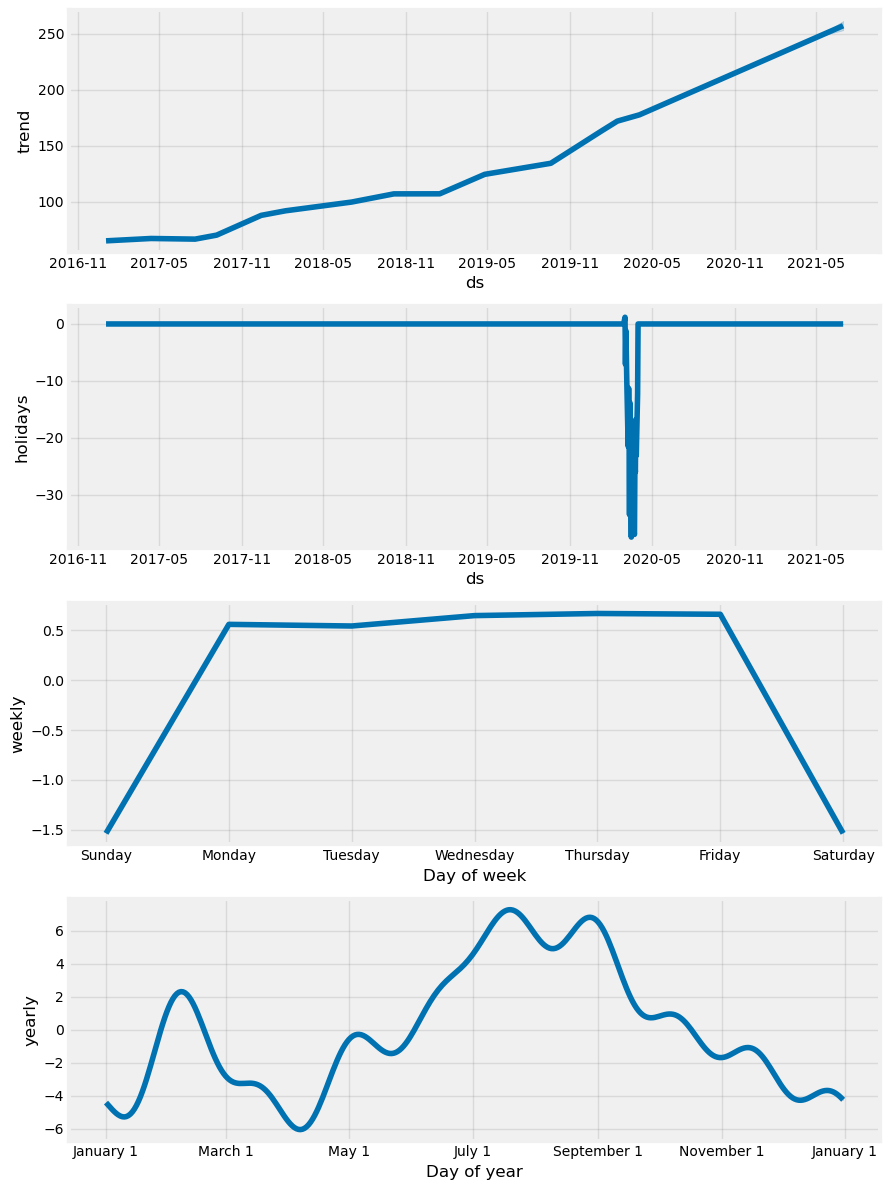

In [212]:
fig2 = model.plot_components(forecast)

In [213]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)


In [214]:
plot_components_plotly(model, forecast)

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\plot.py:865: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Hyperparameter tuning

In [64]:
# Cross validation
baseline_model_cv = cross_validation(model=model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

INFO:prophet:Making 44 forecasts with cutoffs between 2017-08-18 00:00:00 and 2021-02-28 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002358C3F9D30>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-21,73.549249,72.810838,74.356636,72.150002,2017-08-18
1,2017-08-22,73.602250,72.801686,74.321352,73.160004,2017-08-18
2,2017-08-23,73.632579,72.840578,74.394651,72.720001,2017-08-18
3,2017-08-24,73.480495,72.670551,74.224898,72.690002,2017-08-18
4,2017-08-25,73.776761,73.042758,74.579663,72.820000,2017-08-18


In [65]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,99.532516,9.976598,6.465906,0.047374,0.031811,0.050032,0.269824


In [68]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

0.04737443560631177

## Try manual changes on entire model

In [ ]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.8)
# Fit the model on the training dataset
manual_model.fit(stock_data)
# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

## COVID holiday

In [78]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})
# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2017-02-05', '2018-02-04', '2019-02-03','2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,    
})
# Combine all events
#events = pd.concat((COVID, superbowl))
#Or not
events = COVID
# Take a look at the events data
events


,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15


In [79]:
# Add special events
manual_model = Prophet(holidays=events)
# Fit the model on the training dataset
manual_model.fit(stock_data)
# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 44 forecasts with cutoffs between 2017-08-18 00:00:00 and 2021-02-28 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002358C5BE940>


0.04632277837094111

In [96]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(stock_data)  
    # Cross-validation
    df_cv = cross_validation(m,  initial='1457 days', period='7 days', horizon = '90 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023583CA5850>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.proc

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002358C33CEB0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002358C53C310>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pa

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000235873E3640>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000235899DAF70>
INFO:prophet:Disabling daily seasonality. Run 

{'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


In [179]:
# Fit the model using the best parameters
auto_model = Prophet(holidays=events,
                    changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])
# Fit the model on the training dataset
auto_model.fit(train_data)
# Cross validation
auto_model_cv = cross_validation(auto_model, initial='1200', period='30 days', horizon = '90 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p['mape'].values[0]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Making 46 forecasts with cutoffs between 2017-01-21 00:00:00 and 2020-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002358A907F40>


0.48064477539892014

In [180]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='1457 days', period='7 days', horizon = '90 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-30 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [181]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,47.297353,6.877307,6.024675,0.027849,0.027634,0.027348,0.833333
1,12 days,58.007679,7.616277,7.261615,0.033547,0.028358,0.032935,0.666667
2,13 days,72.640012,8.522911,8.121527,0.037606,0.032824,0.036839,0.500000
3,14 days,83.214483,9.122197,8.776414,0.040667,0.041684,0.039789,0.333333
4,15 days,90.460585,9.511077,9.057886,0.041954,0.041684,0.041002,0.333333


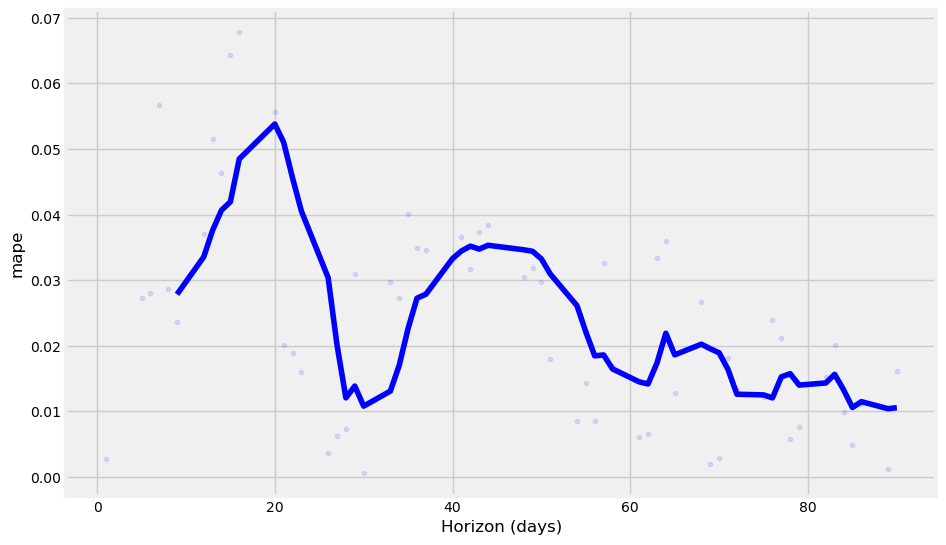

In [182]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window = .1)

In [183]:
df_cv_  = df_cv[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [184]:
df_cv_.head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-12-31,223.038540,216.753818,230.085871
1,2021-01-04,223.618316,216.810270,230.565188
2,2021-01-05,224.008838,217.690376,231.196513
3,2021-01-06,224.277388,217.924137,230.682549
4,2021-01-07,224.550629,217.763367,231.723022


In [185]:
forecast_ = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_ = forecast[900:len(train_data)]

In [186]:
len(forecast_)

107

In [187]:
frames = [forecast_, df_cv_]

result = pd.concat(frames,ignore_index=True)
result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-31,197.110214,196.991288,210.345576,197.110214,197.110214,6.866436,6.866436,6.866436,0.808776,0.808776,0.808776,6.057660,6.057660,6.057660,0.0,0.0,0.0,203.976650
1,2020-08-03,197.677492,197.522778,210.254215,197.677492,197.677492,6.072977,6.072977,6.072977,0.610244,0.610244,0.610244,5.462733,5.462733,5.462733,0.0,0.0,0.0,203.750469
2,2020-08-04,197.866585,197.284397,210.216012,197.866585,197.866585,6.064468,6.064468,6.064468,0.778992,0.778992,0.778992,5.285476,5.285476,5.285476,0.0,0.0,0.0,203.931052
3,2020-08-05,198.055677,197.504463,210.820625,198.055677,198.055677,5.932200,5.932200,5.932200,0.806293,0.806293,0.806293,5.125908,5.125908,5.125908,0.0,0.0,0.0,203.987878
4,2020-08-06,198.244770,197.732917,210.918178,198.244770,198.244770,5.792936,5.792936,5.792936,0.805142,0.805142,0.805142,4.987794,4.987794,4.987794,0.0,0.0,0.0,204.037706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-03-24,NaN,226.185865,239.835739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.126928
164,2021-03-25,NaN,226.262552,239.893418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.478465
165,2021-03-26,NaN,226.595584,241.098878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.852564
166,2021-03-29,NaN,227.867334,242.367340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.959854


In [188]:
len(result)

168

In [189]:
plot_plotly(model, result)

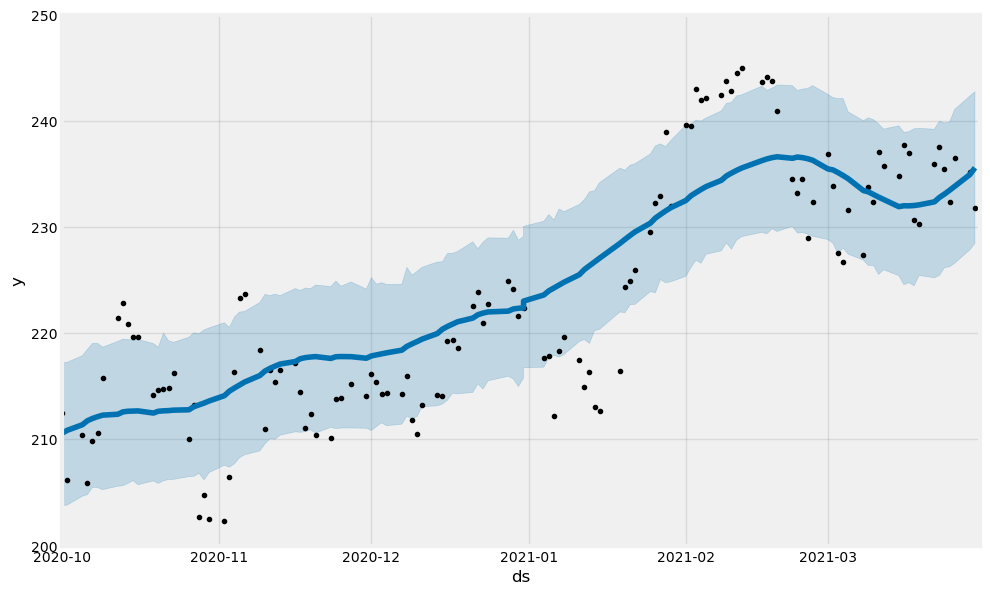

In [190]:
plot = model.plot(result)

plt.xlim(pd.to_datetime(['2020-10-01', '2021-3-31']))
plt.ylim(200,250)
plt.show()

In [282]:
bb = ta.bbands(result['yhat'], length=20,std=1)
bbL = bb.columns[0]
bbU = bb.columns[2]
bbM = bb.columns[1]

In [283]:
def bb_strategy(data_):
    bbBuy = []
    bbSell = []
    position = False
    data_ = pd.concat([data_, bb], axis=1).reindex(data_.index)

    for i in range(len(data_)):
        if data_['yhat'][i] < data_[bbL][i]:
            if position == False :
                bbBuy.append(data_['yhat'][i])
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif data_['yhat'][i] > data_[bbU][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(data_['yhat'][i])
                position = False #To indicate that I actually went there
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    data_['bb_Buy_Signal_price'] = bbBuy
    data_['bb_Sell_Signal_price'] = bbSell

    return data_

In [284]:
#storing the function
data__ = bb_strategy(result)

#data__.tail(25)
data__ = data__.copy()
data__.loc[:, 'ds'] = pd.to_datetime(data__['ds'])
data__.set_index('ds', inplace=True)

C:\Users\noahc\AppData\Local\Temp\ipykernel_1832\2349155483.py:6: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



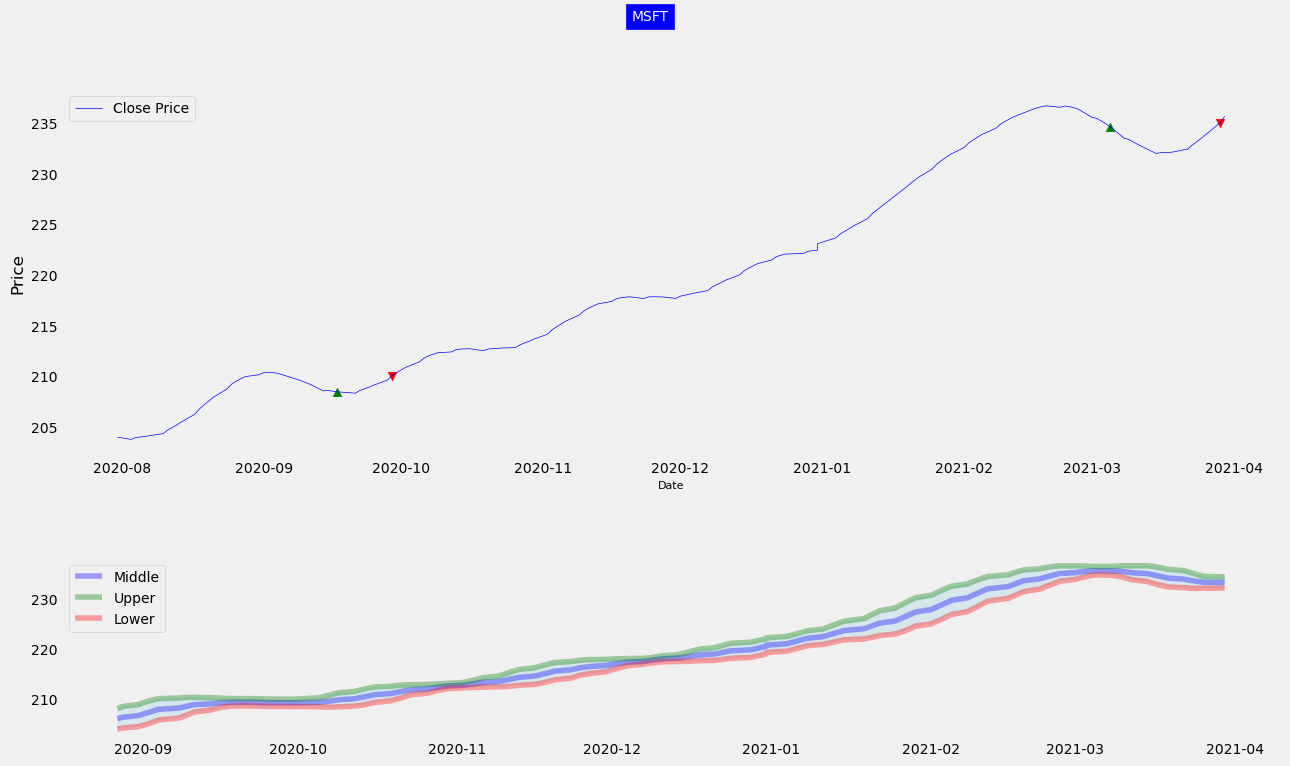

In [285]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle('MSFT', fontsize=10, backgroundcolor='blue', color='white')

ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot(data__['yhat'],label='Close Price', linewidth=0.5, color='blue')
ax1.plot()
ax1.scatter(data__.index, data__['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data__.index, data__['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)

ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(data__[bbM], label='Middle', color='blue', alpha=0.35) #middle band
ax2.plot(data__[bbU], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(data__[bbL], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(data__.index, data__[bbL], data__[bbU], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()

plt.show()

In [195]:
macd = ta.macd(result['yhat'])
macd

C:\Users\noahc\AppData\Local\Temp\ipykernel_1832\2849126742.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
163,-0.259374,-0.214395,-0.044978
164,-0.191373,-0.117116,-0.074257
165,-0.106073,-0.025453,-0.080620
166,0.050297,0.104734,-0.054437


In [196]:
result_ = pd.concat([result, macd], axis=1).reindex(result.index)
result_

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2020-07-31,197.110214,196.991288,210.345576,197.110214,197.110214,6.866436,6.866436,6.866436,0.808776,...,6.057660,6.057660,6.057660,0.0,0.0,0.0,203.976650,NaN,NaN,NaN
1,2020-08-03,197.677492,197.522778,210.254215,197.677492,197.677492,6.072977,6.072977,6.072977,0.610244,...,5.462733,5.462733,5.462733,0.0,0.0,0.0,203.750469,NaN,NaN,NaN
2,2020-08-04,197.866585,197.284397,210.216012,197.866585,197.866585,6.064468,6.064468,6.064468,0.778992,...,5.285476,5.285476,5.285476,0.0,0.0,0.0,203.931052,NaN,NaN,NaN
3,2020-08-05,198.055677,197.504463,210.820625,198.055677,198.055677,5.932200,5.932200,5.932200,0.806293,...,5.125908,5.125908,5.125908,0.0,0.0,0.0,203.987878,NaN,NaN,NaN
4,2020-08-06,198.244770,197.732917,210.918178,198.244770,198.244770,5.792936,5.792936,5.792936,0.805142,...,4.987794,4.987794,4.987794,0.0,0.0,0.0,204.037706,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-03-24,NaN,226.185865,239.835739,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,233.126928,-0.259374,-0.214395,-0.044978
164,2021-03-25,NaN,226.262552,239.893418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,233.478465,-0.191373,-0.117116,-0.074257
165,2021-03-26,NaN,226.595584,241.098878,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,233.852564,-0.106073,-0.025453,-0.080620
166,2021-03-29,NaN,227.867334,242.367340,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,234.959854,0.050297,0.104734,-0.054437


In [197]:
def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['yhat'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['yhat'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['yhat'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["yhat"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['yhat'][i] < df['yhat'][i - 1] * (1 - risk):
            MACD_Sell.append(df["yhat"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    result_['MACD_Buy_Signal_price'] = MACD_Buy
    result_['MACD_Sell_Signal_price'] = MACD_Sell

In [198]:
MACD_strategy = MACD_Strategy(result_, 0.025)
MACD_strategy

In [199]:
def MACD_color(data):
    MACD_color = [False]
    for i in range(1, len(data)):
        if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i-1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    return MACD_color

result_['positive'] = MACD_color(result_)
result_


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Buy_Signal_price,MACD_Sell_Signal_price,positive
0,2020-07-31,197.110214,196.991288,210.345576,197.110214,197.110214,6.866436,6.866436,6.866436,0.808776,...,0.0,0.0,0.0,203.976650,NaN,NaN,NaN,NaN,NaN,False
1,2020-08-03,197.677492,197.522778,210.254215,197.677492,197.677492,6.072977,6.072977,6.072977,0.610244,...,0.0,0.0,0.0,203.750469,NaN,NaN,NaN,NaN,NaN,False
2,2020-08-04,197.866585,197.284397,210.216012,197.866585,197.866585,6.064468,6.064468,6.064468,0.778992,...,0.0,0.0,0.0,203.931052,NaN,NaN,NaN,NaN,NaN,False
3,2020-08-05,198.055677,197.504463,210.820625,198.055677,198.055677,5.932200,5.932200,5.932200,0.806293,...,0.0,0.0,0.0,203.987878,NaN,NaN,NaN,NaN,NaN,False
4,2020-08-06,198.244770,197.732917,210.918178,198.244770,198.244770,5.792936,5.792936,5.792936,0.805142,...,0.0,0.0,0.0,204.037706,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-03-24,NaN,226.185865,239.835739,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,233.126928,-0.259374,-0.214395,-0.044978,NaN,NaN,True
164,2021-03-25,NaN,226.262552,239.893418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,233.478465,-0.191373,-0.117116,-0.074257,NaN,NaN,True
165,2021-03-26,NaN,226.595584,241.098878,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,233.852564,-0.106073,-0.025453,-0.080620,NaN,NaN,True
166,2021-03-29,NaN,227.867334,242.367340,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,234.959854,0.050297,0.104734,-0.054437,234.959854,NaN,True


In [200]:
len(MACD_color(result_))

168

In [201]:
result_.loc[:, 'ds'] = pd.to_datetime(result_['ds'])
result_.set_index('ds', inplace=True)

C:\Users\noahc\AppData\Local\Temp\ipykernel_1832\1984235464.py:1: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



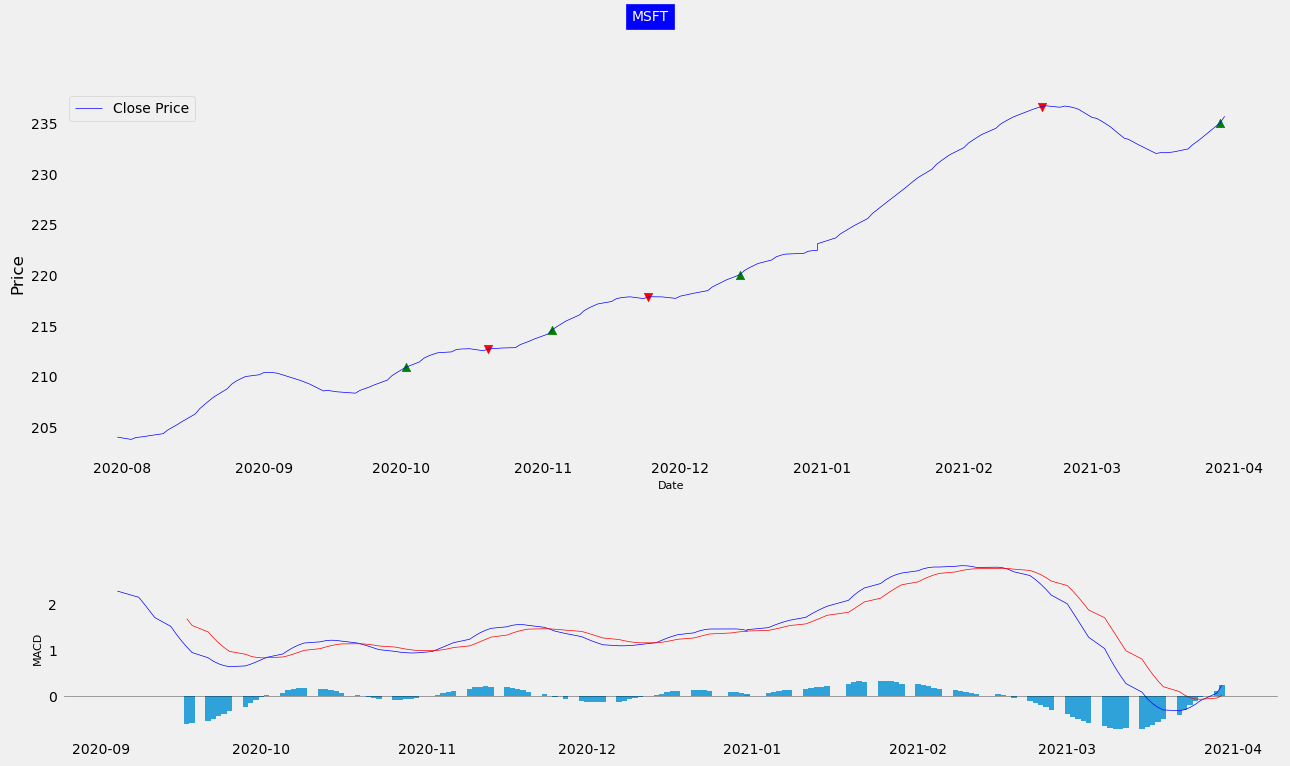

In [202]:
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle('MSFT', fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot('yhat',data=result_, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(result_.index, result_['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(result_.index, result_['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('MACD_12_26_9', data=result_, label='MACD', linewidth=0.5, color='blue')
ax2.plot('MACDs_12_26_9', data=result_, label='signal', linewidth=0.5, color='red')
ax2.bar(result_.index,'MACDh_12_26_9', data=result_, label='Volume',width=1,alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()